#  Principal Component Analysis


  *The code in this notebook has been taken from a [notebook](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb) in the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

  *The code has been released by VanderPlas under the [MIT license](https://opensource.org/licenses/MIT).*

  *Our text is original, though the presentation structure partially follows VanderPlas' presentation of the topic.*
  
    Version: 1.0 (2020/09), Jesús Cid-Sueiro

<!-- I KEEP THIS LINK, MAY BE WE COULD GENERATE SIMILAR COLAB LINKS TO ML4ALL 
<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
-->

In [3]:
# Basic imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Many machine learning applications require the processing of highly **multidimensional** data. More data dimensions usually imply more information to make better predictions. However, a large dimension may state computational problems (the computational load of machine learning algorithms usually grows with the data dimension) and more difficulties to design a good predictor.

For this reason, a whole area of machine learning has been focused on [**feature extraction**](https://en.wikipedia.org/wiki/Feature_extraction) algorithms, i.e. algorithms that transform a multidimensional dataset into data with a reduced set of features. The goal of these techniques is to compute a reduced number of features while preserving the most relevant information for the prediction task.**

Feature extraction (and, more generally, [**dimensionality reduction**](https://en.wikipedia.org/wiki/Dimensionality_reduction)) algorithms are also useful for visualization. By reducing the data dimensions to 2 or 3, we can transform data into points in the plan or the space, and represent them graphically.

**Principal Component Analysis (PCA)** is a particular example of linear feature extraction methods, that compute the new features as linear combinations of the original data components. Besides feature extraction and visualization, PCA is also a usefull tool for noise filtering, as we will see later.

## 1. A visual explanation.

Before going into the mathematical details, we can illustrate the behavior of PCA by looking at a two-dimensional dataset with 200 samples:

(-2.7292712056271964,
 2.5702744393352615,
 -0.9326181575178751,
 1.004413830229183)

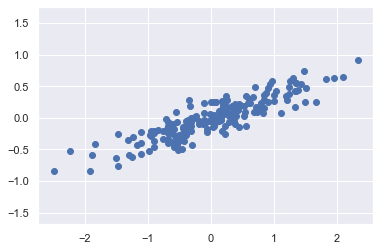

In [4]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')

Note that, in this case, data are zero-mean. If the mean is non-zero, data is usually centered to the origin in before applying PCA.

PCA looks for the principal axes in the data, using them as new coordinates to represent the data points.

We can compute this as follows:

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

After fitting PCA to the data, we can read the directions of the new axes (the *principal* directions) using:

In [6]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


These directions are unit vectors. We can plot them over the scatter plot of the input data, scaled up by the standard deviation of the data along each direction. The standard deviations can be computed as the square root of the variance along each direction, which is available through

In [7]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


The resulting axis plot is the following

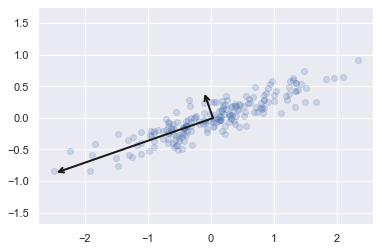

In [8]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

The *principal axes* of the data can be used as a new basis for the data representation. The *principal components* of any point are given by the projections of the point onto each principal axes.


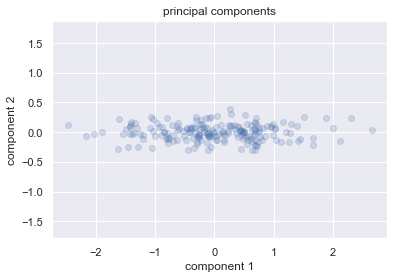

In [9]:
# plot principal components
T = pca.transform(X)
plt.scatter(T[:, 0], T[:, 1], alpha=0.2)
plt.axis('equal')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('principal components')
plt.show()

Note that PCA is essentially an affine transformation: data is centered around the mean and rotated according to the principal directions. At this point, we can select those directions that may be more relevant for prediction.

## 2. Mathematical Foundations

*(The material in this section is based on [Wikipedia: Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis))*

In this section we will see how the principal directions are determined mathematically, and how can they be used to tranform the original dataset. 

PCA is defined as a **linear transformation** that transforms the data to a new **coordinate system** such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

Consider a dataset ${\cal S} = \{{\bf x}_k, k=0,\cdots, K-1\}$ of $m$-dimensional samples arranged by rows in data matrix, ${\bf X}$. Assume the dataset is zero mean, that is
\begin{align}
\sum_{k=0}^{K-1} {\bf x}_k = {\bf 0}
\end{align}
which implies that the sample mean of each column in ${\bf X}$ is zero. If data is not zero-mean, the data matrix ${\bf X}$ is built with rows ${\bf x}_k - {\bf m}$, where ${\bf m}$ is the mean.

PCA transforms each sample ${\bf x}_k \in {\cal S}$ into a vector of principal components ${\bf t}_k$. The transformation is linear so each principal component can be computed as the scalar product of each sample with a weight vector of coefficients. For instance, if the coeficient vectors are ${\bf w}_0, {\bf w}_1, \ldots, {\bf w}_{l-1}$, the principal components of ${\bf x}_k$ are
$$
t_{k0} = {\bf w}_0^\top \mathbf{x}_k,  \\ 
t_{k1} = {\bf w}_1^\top \mathbf{x}_k,  \\
t_{k2} = {\bf w}_2^\top \mathbf{x}_k,  \\
...
$$

These components can be computed iteratively. In the next section we will see how to compute the first one.

### 2.1. Computing the first component

#### 2.2.1. Computing ${\bf w}_0$

The first component is selected in such a way that the sample variance of $t_{00}, t_{10}, \ldots, t_{K-1,0}$ is maximized. Since we can make the variance arbitrarily large by using an arbitrarily large ${\bf w}_0$, we will impose a constraint of the size of the coefficient vectors, that should be unitary. Thus,
$$
\|{\bf w}_0\| = 1
$$

Note that the mean of the transformed components is zero, because samples are zero-mean:
\begin{align}
\sum_{k=0}^{K-1} t_{k0} = \sum_{k=0}^{K-1} {\bf w}_0^\top {\bf x}_k = {\bf w}_0^\top \sum_{k=0}^{K-1} {\bf x}_k ={\bf 0}
\end{align}
therefore, the variance of the first principal component can be computed as

\begin{align}
V &= \frac{1}{K} \sum_{k=0}^{K-1} t_{k0}^2 
   = \frac{1}{K} \sum_{k=0}^{K-1} {\bf w}_0^\top {\bf x}_k {\bf x}_k^\top {\bf w}_0    
   = \frac{1}{K}  {\bf w}_0^\top \left(\sum_{k=0}^{K-1} {\bf x}_k {\bf x}_k^\top \right) {\bf w}_0   \\
  &= \frac{1}{K}  {\bf w}_0^\top {\bf X}^\top {\bf X} {\bf w}_0
\end{align}

The first principal component ${\bf w}_0$ is the maximizer of the variance, thus, it can be computed as
$$
{\bf w}_0 = \underset{\Vert {\bf w} \Vert= 1}{\operatorname{\arg\,max}} \left\{ {\bf w}^\top {\bf X}^\top {\bf X} {\bf w} \right\}$$

Since ${\bf X}^\top {\bf X}$ is necessarily a semidefinite matrix, the maximum is equal to the largest eigenvalue of the matrix, which occurs when ${\bf w}_0$ is the corresponding eigenvector.

#### 2.2.2. Computing $t_{k0}$

Once we have computed the first eigenvector ${\bf w}_0$, we can compute the first component of each sample,
$$
t_{k0} = {\bf w}_0^\top \mathbf{x}_k
$$
Also, we can compute the projection of each sample along the first principal direction as 
$$
t_{k0} {\bf w}_0
$$

We can illustrate this with the example data, applying PCA with only one component

In [12]:
pca = PCA(n_components=1)
pca.fit(X)
T = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", T.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


and projecting the data over the first principal direction:

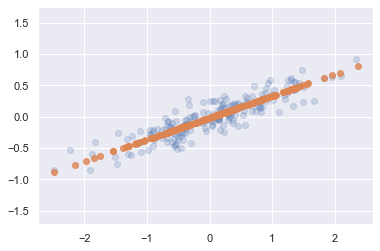

In [13]:
X_new = pca.inverse_transform(T)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### 2.2. Computing further components



The *error*, i.e. the difference between any sample an its projection, is given by
\begin{align}
\hat{\bf x}_{k0} &= {\bf x}_k - t_{k0} {\bf w}_0 = {\bf x}_k - {\bf w}_0 {\bf w}_0^\top \mathbf{x}_k = \\
                 &= ({\bf I} - {\bf w}_0{\bf w}_0^\top ) {\bf x}_k
\end{align}
If we arrange all error vectors, by rows, in a data matrix, we get
$$
\hat{\bf X}_{0} = {\bf X}({\bf I} - {\bf w}_0 {\bf w}_0^T) 
$$

The second principal component can be computed by repeating the analysis in section 2.1 over the error matrix $\hat{\bf X}_{0}$. Thus, it is given by
$$
{\bf w}_1 = \underset{\Vert {\bf w} \Vert= 1}{\operatorname{\arg\,max}} \left\{ {\bf w}^\top \hat{\bf X}_0^\top \hat{\bf X}_0 {\bf w} \right\}
$$

It turns out that this gives the eigenvector of ${\bf X}^\top {\bf X}$ with the second largest eigenvalue.

Repeating this process iterativelly (by substracting from the data all components in the previously computed principal directions) we can compute the third, fourth and succesive principal directions.


### 2.3. Summary of computations

Summarizing, we can conclude that the $l$ principal components of the data can be computed as follows: 

 1. Compute the $l$ unitary eigenvectors ${\bf w}_0, {\bf w}_1, \ldots, {\bf w}_{l-1}$ from matrix ${\bf X}^\top{\bf X}$ with the $l$ largest eigenvalues.
 2. Arrange the eigenvectors columnwise into an $m \times l$ weight matrix ${\bf W} = ({\bf w}_0 | {\bf w}_1 | \ldots | {\bf w}_{l-1})$
 3. Compute the principal components for all samples in data matrix ${\bf X}$ as
$$
{\bf T} = {\bf X}{\bf W}
$$

The computation of the eigenvectors of ${\bf X}^\top{\bf X}$ can be problematic, specially if the data dimension is very high. Fortunately, there exist efficient algorithms for the computation of the eigenvectors without computing ${\bf X}^\top{\bf X}$, by means of the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of matrix ${\bf X}$. This is the method used by the PCA method from the `sklearn` library

## 2. PCA as dimensionality reduction

After a PCA transformation, we may find that the variance of the data along some of the principal directions is very small. Thus, we can simply remove those directions, and represent data using the components with the highest variance only.

In the above 2-dimensional example, we selected the principal direction only, and all data become projected onto a single line.

The key idea in the use of PCA for dimensionality reduction is that, if the removed dimensions had a very low variance, we can expect a small information loss for a prediction task. Thus, we can try to design our predictor with the selected features, with the hope to preserve a good prediction performance.

## 3. PCA for visualization: Hand-written digits

In the illustrative example we used PCA to project 2-dimensional data into one dimension, but the same analysis can be applied to project $N$-dimensional data to $r<N$ dimensions. An interesting application of this is the projection to 2 or 3 dimensions, that can be visualized.

We will illustrate this using the digits dataset:

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

This dataset contains $8\times 8$ pixel images of digit manuscritps. Thus, each image can be converted into a 64-dimensional vector, and then projected over into two dimensions:

In [16]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Every image has been tranformed into a 2 dimensional vector, and we can represent them into a scatter plot:

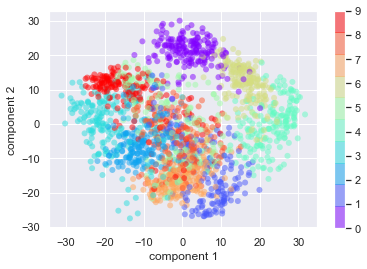

In [17]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Note that we have just transformed a collection of digital images into a cloud of points, using a different color to represent the points corresponding to the same digit. Note that colors from the same digit tend to be grouped in the same cluster, which suggests that these two components may contain useful information for discriminating between digits. Clusters show some overlap, so maybe using more components could help for a better discrimination.

The example shows that, despite a 2-dimensional projection may loose relevant information for a prediction task, the visualization of this projections may provide some insights to the data analyst on the predition problem to solve.

### 3.1. Interpreting principal components

Note that an important step in the application of PCA to digital images is the vectorization: each digit image is converted into a 64 dimensional vector:
$$
{\bf x} = (x_0, x_1, x_2 \cdots x_{63})^\top
$$
where $x_i$ represents the intesity of the $i$-th pixel in the image. We can go back to reconstruct the original image as follows: if $I_i$ is an black image with unit intensity at the $i$-th pixel only, we can reconstruct the original image as 
$$
{\rm image}({\bf x}) = \sum_{i=0}^{63} x_i I_i
$$

A crude way to reduce the dimensionality of this data is to remove some of the components in the sum. For instance, we can keep the first eight pixels, only. But we then we get a poor representation of the original image:

In [21]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], f'$c_{i}$')
        show(1, i + counter, approx, f"${coefficients[i]:.2f} \cdot c_{i}$")
             #r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

PCA provides an alternative basis for the image representation. Using PCA, we can represent each vector as linear combination of the principal direction vectors ${\bf w}_0, {\bf w}_1, \cdots, {\bf w}_{63}$:
$$
{\bf x} = {\bf m} + \sum_{i=0}^{63} t_i {\bf w}_i
$$
and, thus, we can represent the image as the linear combination of the images associated to each direction vector
$$
image({\bf x}) = image({\bf m}) + \sum_{i=0}^{63} t_i \cdot image({\bf w}_i)
$$

PCA selects the principal directions in such a way that the first components capture most of the variance of the data. Thus, a few components may provide a good approximation to the original image.

The figure shows a reconstruction of a digit using the mean image and the first eight PCA components:

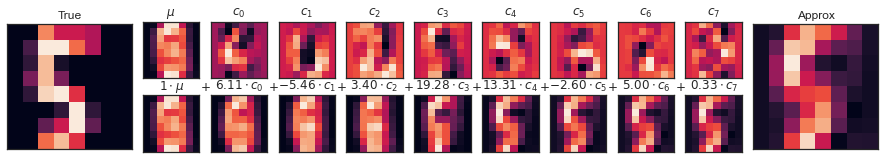

In [28]:
idx = 25  # Select digit from the dataset
pca = PCA(n_components=10)
Xproj = pca.fit_transform(digits.data)
sns.set_style('white')
fig = plot_pca_components(digits.data[idx], Xproj[idx],
                          pca.mean_, pca.components_)


## 4. Choosing the number of components

The number of components required to approximate the data can be quantified by computing the cumulative *explained variance ratio* as a function of the number of components:

[0.14890594 0.28509365 0.40303959 0.48713938 0.54496353 0.59413263
 0.6372925  0.67390623 0.70743871 0.73822677 0.76195018 0.78467714
 0.80289578 0.82063433 0.83530534 0.84940249 0.86258838 0.87506976
 0.88524694 0.89430312 0.9031985  0.91116973 0.91884467 0.9260737
 0.93303259 0.9389934  0.94474955 0.94990113 0.95479652 0.9590854
 0.96282146 0.96635421 0.96972105 0.97300135 0.97608455 0.97902234
 0.98158823 0.98386565 0.98608843 0.98820273 0.99010182 0.99168835
 0.99319995 0.99460574 0.99577196 0.99684689 0.99781094 0.99858557
 0.99914278 0.99954711 0.99975703 0.99983951 0.99989203 0.99994255
 0.99997555 0.99998798 0.99999503 0.99999804 0.99999911 0.99999966
 1.         1.         1.         1.        ]


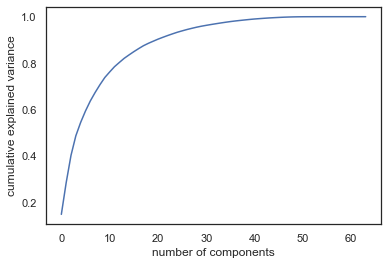

In [17]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
print(np.cumsum(pca.explained_variance_ratio_))

In this curve we can see that the 16 principal components explain more than 86 % of the data variance. 32 out of 64 components explain 96.6 % of the data variance. This suggest that the original data dimension can be substantally reduced.


## 5. PCA as Noise Filtering

The use of PCA for noise filtering can be illustrated with some examples from the digits dataset.

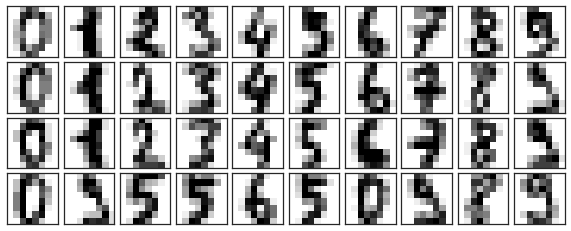

In [18]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

As we have shown before, the majority of the data variance is concentrated in a fraction of the principal components. Now assume that the dataset is affected by AWGN noise:

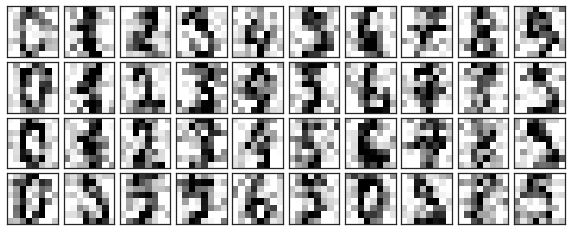

In [19]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It is not difficult to show that, in the noise samples are independent for all pixels, the noise variance over all principal directions is the same. Thus, the principal components with higher variance will be less afected by nose. By removing the compoments with lower variance, we will be removing noise, majoritarily.

Let's train a PCA on the noisy data, requesting that the projection preserve 55% of the variance:

In [27]:
pca = PCA(0.55).fit(noisy)
pca.n_components_

15

15 compoments contain this amount of variance. The corresponding images are shown below:

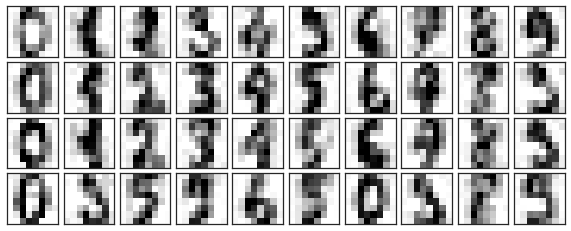

In [29]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This is another reason why PCA works well in some prediction problems: by removing the components with less variance, we can be removing mostly noise, keeping the relevant information for a prediction task in the selected components.

## 6. Example: Eigenfaces

We will see another application of PCA using the Labeled Faces in the Wild dataset taken from Scikit-Learn:

In [31]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


We will take a look at the first 150 principal components. Because of the large dimensionality of this dataset (close to 3000), we will select the ``randomized`` solver for a fast approtimation to the first $N$ principal components.


In [32]:
#from sklearn.decomposition import Randomized PCA
pca = PCA(150, svd_solver="randomized")
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

Now, let us visualize the images associated to the eigenvectors of the first principal components (the "eigenfaces"). These are the basis images, and all faces can be approximated as linear combinations of them.


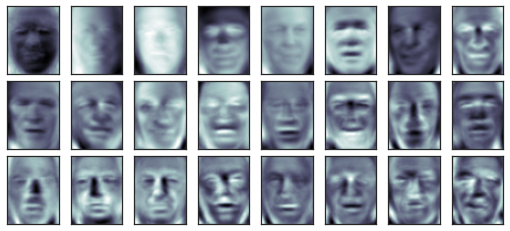

In [33]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Note that some eigenfaces seem to be associated to the lighting conditions of the image, an other to specific features of the faces (noses, eyes, mouth, etc).

The cumulative variance shows that 150 components cope with more than 90 % of the variance:

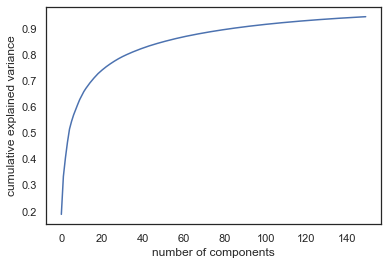

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We can compare the input images with the images reconstructed from these 150 components:

In [37]:
# Compute the components and projected faces
pca = PCA(150, svd_solver="randomized").fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

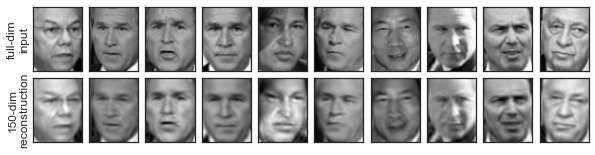

In [38]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

Note that, despite some image resolution is loss, only 150 features are enough to recognize the faces in the image. This shows the potential of PCA as a preprocessing step to reduce de dimensionality of the data (in this case, for more than 3000 to 150) without loosing prediction power.